## LeNet implementation from scratch 

LeNet is one of the earliest convolutional neural network (CNN) architectures, developed by Yann LeCun and his colleagues in the 1990s. It was primarily designed for handwritten digit recognition but laid the groundwork for many modern CNN architectures.

LeNet was a breakthrough in the field of deep learning and computer vision.
It demonstrated that:

- Convolutional neural networks can effectively learn hierarchical features.
- Gradient-based learning can train deep neural networks.
- CNNs can be applied to practical problems like digit recognition.

But, LeNet has some limitations:
- Limited depth compared to modern architectures
- Use of average pooling instead of max pooling
- Tanh activation function instead of ReLu

Modern CNN architectures like AlexNet, VGGNet, and ResNet have built upon LeNet's foundations, incorporating deeper neural networks, different activation functions, and advanced training techniques

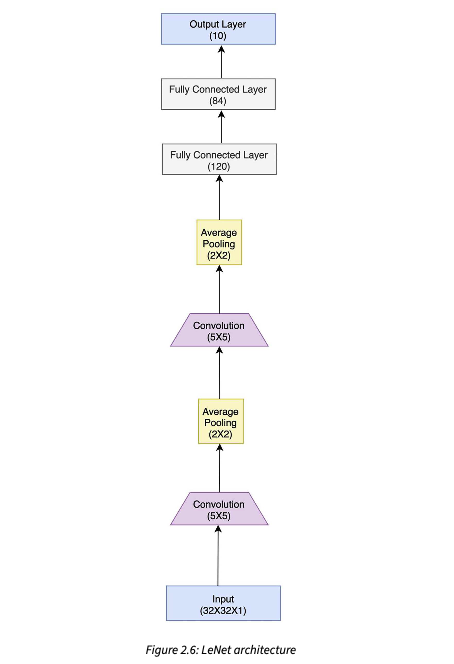

<i> Source: Mastering PyTorch book 2nd edition </i>

In this tutorial, we will learn to implement LeNet model architecture from scratch and test this CNN architecture on MNIST digit dataset and check it accuracy. We will check the LeNet model performance on digit classification task by making some modifications its architecture like using ReLu activation function and max pooling instead of Tanh activation function and average pooling respectively.   

For this tutorial, we will use macbook laptop. So, we will use "mps" instead of "cuda" when we want to perform tensor operations using gpu. 

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms import (ToTensor, Normalize, 
                                    Compose, Resize, Grayscale, RandomCrop,
                                    RandomHorizontalFlip, RandomRotation, 
                                    RandomResizedCrop, RandomAffine, ColorJitter)
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


 # for reproducibility
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [28]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

We will implement the original LeNet architecture from scratch with some modifications as we mentioned above. 



In [29]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Adjusted for 28x28 input
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = x.view(-1, 16 * 4 * 4)  # Adjusted for 28x28 input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


We wiill prepprocess the image and  use dataloaders for faster training and inference. 

In [30]:

# Data loading and preprocessing
train_transform = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=train_transform),
    batch_size=64, shuffle=True
)

test_loader = DataLoader(
    datasets.MNIST('data', train=False, download=True, transform=test_transform),
    batch_size=1000, shuffle=False
)


we will write "train" function to train the model

In [31]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

We will write "test" function to test the model

In [32]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.2f}%)\n')

Finally, we set up our model, optimizer, and loss function, and run the training loop:

In [33]:
model = LeNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)
    test(model, device, test_loader, criterion)

print("Training completed.")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320144
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.095398
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.444235
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.745387
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.683085
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.539244
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.237485
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.240834
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.107934
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.122780

Test set: Average loss: 0.0001, Accuracy: 9503/10000 (95.03%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.255150
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.081756
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.110770
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.242849
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.363452
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.247096
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.072626
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.087328
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.13056

### Conclusion


Implementing LeNet from scratch provides a deep understanding of the fundamentals of CNNs. While modern architectures have surpassed LeNet in performance, the principles behind it remain relevant. By studying and implementing classic architectures like LeNet, we gain invaluable insights that can inform our understanding and use of more complex modern networks.
As you experiment with this implementation, consider trying different optimizers, adjusting the learning rate, or even modifying the architecture slightly. Each change will deepen your understanding of how CNNs work and how they can be optimized.
Remember, in the world of deep learning, understanding the classics is often the key to mastering the cutting edge.